In [1]:
from IPython.core.display import HTML
HTML("<style>.container { width:90% !important; } div.cell.selected { border-left-width: 1px !important;}</style>")

<div style=float:right><img src="assets/img/appliedai-logo.png" width=100 style="margin: 0px 20px"></img></div>


##### Jonathan Sedar Personal Project
## PyMC3 vs PyStan Comparison
_Spring 2016_

This set of Notebooks and scripts comprise the **pymc3_vs_pystan** personal project by Jonathan Sedar of Applied AI Ltd, written primarily for presentation at the PyData London 2016 Conference.

The project demonstrates hierarchical linear regression using two Bayesian inference frameworks: PyMC3 and PyStan. The project borrows heavily from code written for Applied AI Ltd and is supplied here for educational purposes only. No copyright or license is extended to users.


    
# 40_HierarchicalLinearRegression

#### Demonstrate pooling and hierarchical linear regression


Create a set of progressively more complex models, trying to show the effect of manufacturer upon NOx emissions. I'll evaluate the models using WAIC and PPC.

+ [Setup](#Setup)
    + [Local Functions](#Local-Functions)
    + [Load Data](#Load-Data)
    + [Prepare Dataset](#Prepare-Dataset)
    + [Describe Dataset](#Describe-Dataset)


+ [Choose Features](#Choose-Features)
    + [Create Modelspecs and Design Matrices](#Create-Modelspecs-and-Design-Matrices)


+ [Pooled Model](#Pooled-Model)


+ [Unpooled Model](#Unpooled-Model)
    + [Evaluate Manufacturers using Unpooled Model](#Evaluate-Manufacturers-using-Unpooled-Model)
    
    
+ [Digression: Fully Unpooled Model](#Digression:-Fully-Unpooled-Model)


+ [Partially-Pooled Model](#Partially-Pooled-Model)
    + [Evaluate Manufacturers using Partially-Pooled Model](Evaluate-Manufacturers-using-Partially-Pooled-Model)
    + [Can we comment on Volkswagen's NOx emissions at `mfr` level?](#Can-we-comment-on-Volkswagen's-NOx-emissions at `mfr` level?)


+ [Hierarchical Model of Parent and Manufacturer](#Hierarchical-Model-of-Parent-and-Manufacturer)



+ [Summary Insights and Notes](#Summary-Insights-and-Notes)
    + [Model Comparison using WAIC](#Model-Comparison-using-WAIC)
    + [Comparing Car Manufacturers and Parent Companies](Comparing-car-manufacturers-and-parent-companies)




+ [Digression: Model Comparison using WAIC](#Digression:-Model-Comparison-using-WAIC)


+ [Final look at parent with a Partially-Pooled Model](#Final-look-at-parent-with-a-Partially-Pooled-Model)
    + [Evaluate Manufacturers using Partially-Pooled `parent` Model](Evaluate-Manufacturers-using-Partially-Pooled-`parent`-Model)
    + [Can we comment on Volkswagen's NOx emissions at `parent` level?](#Can-we-comment-on-Volkswagen's-NOx-emissions at `parent` level?)



# Bayesian Hierarchical Linear Regression in PyMC3 and PyStan

# Setup

In [2]:
## Interactive magics
%matplotlib inline
%qtconsole --colors=linux
# %connect_info

In [3]:
# filter warnings for presentation's sake
import warnings
warnings.filterwarnings('ignore')

# general packages
import sys
from time import time
from collections import defaultdict, OrderedDict
import sqlite3
from convenience_functions import *
from ipywidgets import interactive, fixed

# scientific packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import patsy as pt
from scipy import optimize
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.neighbors.kde import KernelDensity
import statsmodels.api as sm

# pymc3 libraries
import pymc3 as pm
import theano as thno
import theano.tensor as T 
import pystan

# filter warnings for presentation's sake
import warnings
warnings.filterwarnings('ignore')

sns.set(style="darkgrid", palette="muted")
pd.set_option('display.mpl_style', 'default')
plt.rcParams['figure.figsize'] = 12, 4
np.random.seed(0)

dfwaic_pymc = pd.DataFrame() # setup for WAIC evaluations

##### Package Versions

In [4]:
%install_ext https://raw.githubusercontent.com/rasbt/watermark/master/watermark.py
%load_ext watermark
print('Recursion limit {}'.format(sys.getrecursionlimit()))
%watermark -dmvgp numpy,scipy,pandas,matplotlib,pymc3,theano,pystan

Installed watermark.py. To use it, type:
  %load_ext watermark
Recursion limit 10000
2016-05-06 

CPython 3.5.1
IPython 4.1.2

numpy 1.11.0
scipy 0.17.0
pandas 0.18.0
matplotlib 1.5.1
pymc3 3.0
theano 0.8.1
pystan 2.9.0.0

compiler   : GCC 4.2.1 (Apple Inc. build 5577)
system     : Darwin
release    : 14.5.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit
Git hash   : 321dafd7a6a4a5d39462a53a19d79382ca759196


##### Set switches for run-all convenience

In [5]:
sample_switches = {'pooled':{'pymc':0, 'stan':0},
                   'unpooled':{'pymc':0, 'stan':0},
                   'fullyunpooled':{'pymc':0},
                   'partpooled':{'pymc':0, 'stan':0},
                   'hier':{'pymc':0, 'stan':0}}

## Local Functions

In [6]:
def create_smry(trc, dfs, pname='mfr'):
    ''' Conv fn: create trace summary for sorted forestplot '''

    dfsm = pm.df_summary(trc).reset_index()
    dfsm.rename(columns={'index':'featval'}, inplace=True)
    dfsm = dfsm.loc[dfsm['featval'].apply(
        lambda x: re.search('{}__[0-9]+'.format(pname), x) is not None)]

    dfsm.set_index(dfs[pname].unique(), inplace=True)
    dfsm.sort('mean', ascending=True, inplace=True)
    dfsm['ypos'] = np.arange(len(dfsm))
    
    return dfsm


def custom_forestplot(df, sg, ylabel='mfr', size=8, aspect=0.8, facetby=None):
    ''' Conv fn: plot features from pm.df_summary using seaborn
        Facet on sets of forests for comparison '''

    g = sns.FacetGrid(col=facetby, hue='mean', data=df, palette='RdBu_r'
                      ,size=size, aspect=aspect, sharey=True)
    _ = g.map(plt.scatter, 'mean', 'ypos'
                ,marker='o', s=100, edgecolor='#333333', linewidth=0.8, zorder=10)
    _ = g.map(plt.hlines, 'ypos', 'hpd_2.5','hpd_97.5', color='#aaaaaa')

    _ = g.axes.flat[0].set_ylabel(ylabel)
    _ = [ax.set_xlabel('coeff value') for ax in g.axes.flat]
    _ = g.axes.flat[0].set_ylim((-1, df['ypos'].max()+1))
    _ = g.axes.flat[0].set_yticks(np.arange(df['ypos'].max()+1))
    _ = g.axes.flat[0].set_yticklabels(df.index)

    if sg is not None:
        # hacky way to show group sizes at rhs
        sg = sg[df.iloc[:len(df)//len(g.axes.flat),:].index]    ## ensure index order
        _ = axr = g.axes.flat[len(g.axes.flat)-1].twinx()
        _ = axr.plot(np.zeros(len(sg)), range(len(sg)), lw=0)
        _ = axr.set_ylim((-1,len(sg)))
        _ = axr.set_yticks([l for l in range(len(sg))])
        _ = axr.set_yticklabels(sg)
        _ = axr.yaxis.grid(False)
        _ = axr.spines['top'].set_visible(False)
        _ = axr.spines['right'].set_visible(False)
        
    
def custom_2d_forestplot(dfg, show='Zoom'):
    ''' Conv fn: custom 2d forestplot of parent and mfr, optional CRs 
        NOTE legend hack to cope with open issue with FacetGrid hue and plt.scatter
        https://github.com/mwaskom/seaborn/issues/840
    
    '''    

    g = sns.FacetGrid(data=dfg, size=12, aspect=0.8)

    _ = g.map(plt.scatter, 'mean_parent', 'mean_mfr',
              marker='o', s=100, edgecolor='#333333', linewidth=0.8, zorder=10,
              c=[sns.color_palette('Spectral', 20).as_hex()[m] for m in dfg['parent_order_id']])
    
    ylim_zoom = g.axes.flat[0].get_ylim()
    xlim_zoom = g.axes.flat[0].get_xlim()
    
    _ = g.map(plt.hlines, 'mean_mfr', 'hpd_2.5_parent', 'hpd_97.5_parent', color='#bbbbbb')
    _ = g.map(plt.vlines, 'mean_parent', 'hpd_2.5_mfr', 'hpd_97.5_mfr', color='#bbbbbb')

    # hack autogen legend to show only parent dots
    # hnd, lbl = g.axes.flat[0].get_legend_handles_labels()
    # _ = g.axes.flat[0].legend(hnd[:20], lbl[:20], loc='upper left', ncol=1,
    #     title='parent', frameon=True, framealpha=0.5).get_frame().set_facecolor('w')

    # Manually create legend from custom artist/label lists
    legcolors = [plt.Line2D([0,0],[0,1],
                            color=sns.color_palette('Spectral', 20).as_hex()[p],
                            ms=10, marker='o', mec='#333333', mew=1, linestyle='')
                 for p in range(20)]
    
    _ = g.axes.flat[0].legend(legcolors,
                              dfg['parent'].drop_duplicates().values.tolist(),
                loc='upper left', ncol=1, title='parent', frameon=True, 
                framealpha=0.5, numpoints=1).get_frame().set_facecolor('w')

    _ = g.axes.flat[0].set_ylabel('mfr')
    _ = g.axes.flat[0].set_xlabel('parent')

    for i, r in dfg[['mfr','n','mean_parent','mean_mfr']].iterrows():
        _ = g.axes.flat[0].annotate('{} ({})'.format(r[0],r[1]), #.split(' - ')[1]
                         xy=(r[2], r[3]), xycoords='data',
                         xytext=(5,5), textcoords='offset points',
                         color='#444444', fontsize=10, rotation=30, va='bottom')
    if show == 'Zoom':
        _ = g.axes.flat[0].set_ylim(ylim_zoom)
        _ = g.axes.flat[0].set_xlim(xlim_zoom) 
        

## Load Data

In [7]:
cnxsql = sqlite3.connect('data/car_emissions.db')
dfs = pd.read_sql('select * from cars_post_exclusions_2sd', cnxsql, index_col=None)

In [8]:
## convert sqlite bool storage (as ints) back to bools
for ft in ['parent_is_vw', 'mfr_is_vw', 'is_tdi']:
    dfs[ft] = dfs[ft].astype(bool)

In [9]:
custom_describe(dfs)

(2590, 13)


,1653,835,763,count,mean,std,min,25%,50%,75%,max,dtype
emissions_nox_mgkm,12,36,32,2590,37.34,17.89,1,23.000000,35.000000,51.000000,76,float64
parent_is_vw,False,False,False,2590,NaN,NaN,False,NaN,NaN,NaN,True,bool
mfr_is_vw,False,False,False,2590,NaN,NaN,False,NaN,NaN,NaN,True,bool
parent,daimler-ag,bmw,bmw,2590,NaN,NaN,aston,NaN,NaN,NaN,volksw,object
mfr,mercedes-benz,bmw,bmw,2590,NaN,NaN,abarth,NaN,NaN,NaN,volvo,object
trans,auto,semiauto,auto,2590,NaN,NaN,auto,NaN,NaN,NaN,semiau,object
fuel_type,petrol,petrol,petrol,2590,NaN,NaN,diesel,NaN,NaN,NaN,petrol,object
is_tdi,False,False,False,2590,NaN,NaN,False,NaN,NaN,NaN,True,bool
metric_combined,-0.0729888,0.806396,0.220139,2590,-0.00,0.50,-0.685893,-0.332807,-0.152933,0.166843,2.7517,float64
metric_extra_urban,-0.0752461,0.474268,0.0727001,2590,0.00,0.50,-0.476814,-0.180922,-0.075246,0.093835,21.5883,float64


##### Label encode `mfr` and `mfr_owner`

In [10]:
le = LabelEncoder()
dfs['mfr_enc'] = le.fit_transform(dfs['mfr'])
dfs['parent_enc'] = le.fit_transform(dfs['parent'])

n_parent = dfs['parent_enc'].max()+1
n_mfr = dfs['mfr_enc'].max()+1

##### Declare feats for use

In [11]:
fts_cat = ['parent_is_vw', 'mfr_is_vw', 'parent', 'mfr', 'trans', 'fuel_type', 'is_tdi']
fts_cat_smp = ['mfr_is_vw','trans','fuel_type','is_tdi']
fts_num = ['metric_combined', 'metric_extra_urban', 'metric_urban_cold'
           ,'engine_capacity', 'emissions_co_mgkm']
fts_num_smp = ['metric_combined', 'engine_capacity', 'emissions_co_mgkm']
ft_endog = 'emissions_nox_mgkm'

## Describe dataset

+ The dataset is 2593 rows, with 12 exog features, 1 endog feature.
+ These are observations of car emissions tests, one row per car.
+ You can read off the basic distributional statistics of the features in the table above. Numeric features have been standardized according to [Gelman's 2sd principle](http://www.stat.columbia.edu/~gelman/research/published/standardizing7.pdf).
+ I have selected these particular 12 features to work with. Some are derivatives of original features.

We have the following features to choose from:

```
+ Categoricals:
    + `trans`     - the car transmission, simplified to 'auto', 'semiauto', 'manual'
    + `fuel_type` - the car power supply, simplified to 'petrol', 'diesel'
    + `parent`    - the parent company of the car manufacturer, 20 values
    + `mfr`       - the car manufacturer, 38 values

+ Booleans:
    + `parent_is_vw` - if the parent company of the car manufacturer is Volkswagen
    + `mfr_is_vw`    - if the car manufacturer is Volkswagen
    + `is_tdi`       - (processed feature) if the car engine type is a turbo diesel
    
+ Numerics:
    + `metric_combined`    - a score for fuel efficiency in combined driving
    + `metric_extra_urban` - a score for fuel efficiency in an extra-urban driving
    + `metric_urban_cold`  - a score for fuel efficiency in an urban setting, cold start
    + `emissions_co_mgkm`  - a count of CO particulates emitted mg/km
    
+ Numeric endogenous feature:
    + `emissions_nox_mgkm` - a count of NOx particulates emitted mg/km    
```

For the purposes of this Notebook, the final feature mentioned `emissions_nox_mgkm` will be used as the _endogenous_ / _dependent_ / _output_ feature of the linear models. All other features may be used as _exogenous_ / _independent_ / _input_ features.

---

---

# Choose Features

Note: I will use this `glm` model specification for the pooled model. I will have to manually specify the unpooled, partially-pooled and hierarchical models.

```
endogenous feature: emissions_nox_mgkm

exogenous features: parent              : multi-class string
                    mfr                 : multi-class string
                    fuel_type           : multi-class string
                    trans               : multi-class string
                    is_tdi              : boolean
                    engine_capacity     : numeric int
                    metric_combined     : numeric int
                    emissions_co_mgkm   : numeric float
```

##### Reminder of mfr and parent counts:

In [12]:
print('parent: {} uniques\nmfr: {} uniques'.format(
        len(dfs['parent'].unique()), len(dfs['mfr'].unique())))

parent: 20 uniques
mfr: 38 uniques


## Create Modelspecs and Design Matrices

##### Only possible to use this formula for pooled model

In [13]:
fml_pooled = '{} ~ '.format(ft_endog) + ' + '.join(['fuel_type','trans'
            ,'is_tdi','engine_capacity','metric_combined','emissions_co_mgkm'])
print(fml_pooled)

emissions_nox_mgkm ~ fuel_type + trans + is_tdi + engine_capacity + metric_combined + emissions_co_mgkm


In [14]:
(mx_en, mx_ex) = pt.dmatrices(fml_pooled, dfs
                        ,return_type='dataframe', NA_action='raise')
mx_ex.head()

,Intercept,fuel_type[T.petrol],trans[T.manual],trans[T.semiauto],is_tdi[T.True],engine_capacity,metric_combined,emissions_co_mgkm
0,1.0,1.0,1.0,0.0,0.0,-0.384683,0.086899,-0.166104
1,1.0,1.0,1.0,0.0,0.0,-0.384683,0.220139,-0.166104
2,1.0,1.0,0.0,1.0,0.0,-0.384683,0.033603,0.624679
3,1.0,1.0,0.0,1.0,0.0,-0.384683,0.220139,0.624679
4,1.0,1.0,1.0,0.0,0.0,-0.384683,0.086899,-0.166104


---

---

# Pooled Model

Pool (ignore) the `parent` and `mfr` features.

$$y \sim \mathcal{N}(\beta^{T} \bf{x},\epsilon)$$

where:  
$\beta$ are our coeffs in the linear model  
$\bf{x}$ is the vector of features describing each car in the dataset  
$\epsilon \sim \mathcal{HalfCauchy}(0, 10)$ 

I'll attempt to robustly handle outliers this time by using a Student-T distribution for the likelihood, the error-term $\epsilon$ is stochastic noise in the likelihood of that model.

---

## PyMC3 Model

In [15]:
if 0 == 1: ## show code but don't run
    with pm.Model() as mdl_pooled_pymc:

        pm.glm.glm(('emissions_nox_mgkm ~ fuel_type + trans + is_tdi + engine_capacity +' + 
                                         'metric_combined + emissions_co_mgkm'),
                   dfs,
                   family=pm.glm.families.StudentT())

##### Create model and sample

In [16]:
if sample_switches['pooled']['pymc']:

    with pm.Model() as mdl_pooled_pymc:

        run = OrderedDict()
        run['start'] = time()
        
        pm.glm.glm(fml_pooled, dfs, family=pm.glm.families.StudentT())

        run['build'] = time()
        
        start_map = pm.find_MAP(fmin=optimize.fmin_powell)
        
        run['find_map'] = time()
        
        trc_pooled_pymc = pm.sample(4000, njobs=1, step=pm.NUTS(),
                               start=start_map,
                               trace=pm.backends.Text('traces/trc_pooled_pymc'))

        run['sample'] = time()
        
    ## dump to disk    
    write_pickle(obj=mdl_pooled_pymc, relnm='models/mdl_pooled_pymc.pkl')
    write_pickle(obj=run, relnm='models/mdl_pooled_pymc_runtime.pkl')
    mdl_pooled_pymc_run = run
    
else:
    with pm.Model():   ## read from disk

        mdl_pooled_pymc = read_pickle(relnm='models/mdl_pooled_pymc.pkl')
        mdl_pooled_pymc_run = read_pickle(relnm='models/mdl_pooled_pymc_runtime.pkl')

    trc_pooled_pymc = pm.backends.text.load('traces/trc_pooled_pymc', model=mdl_pooled_pymc)

Applied log-transform to lam and added transformed lam_log to model.
 [-----------------100%-----------------] 4000 of 4000 complete in 67.8 sec

##### Save WAIC and view traces

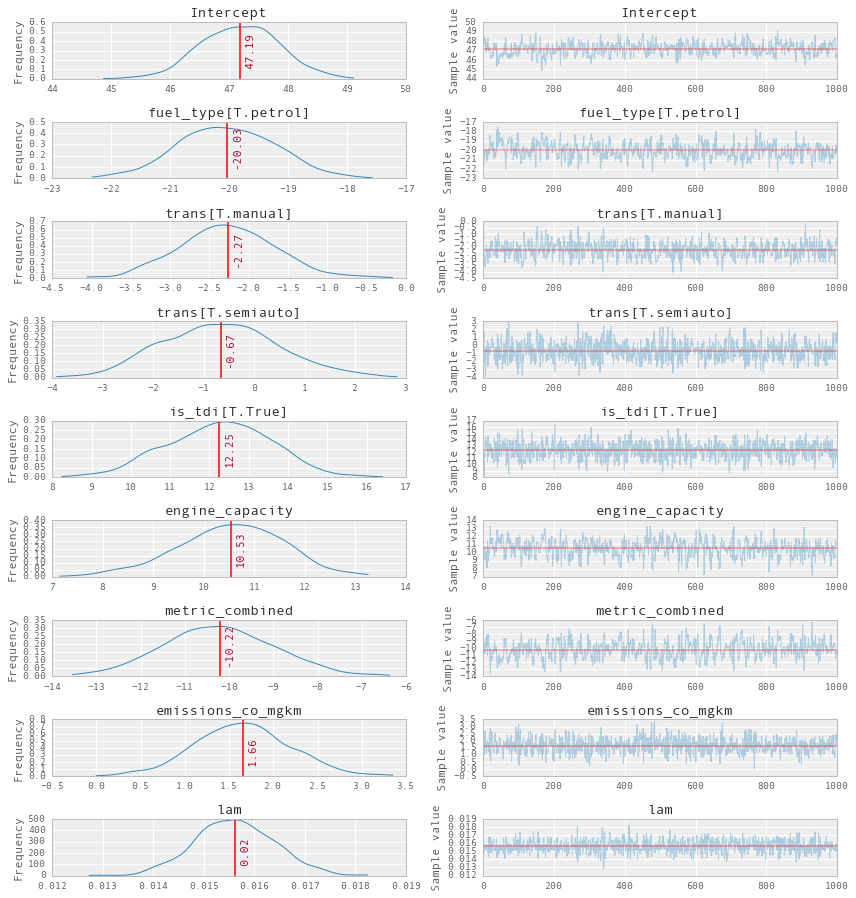

In [17]:
dfwaic_pymc['pooled'] = [pm.stats.waic(model=mdl_pooled_pymc, trace=trc_pooled_pymc[-1000:])]

rvs_pooled = [rv.name for rv in strip_derived_rvs(mdl_pooled_pymc.unobserved_RVs)]
plot_traces_pymc(trc_pooled_pymc[-1000:], varnames=rvs_pooled)

**Observe**:


+ Stuff



---

## PyStan Model

##### Spec model

In [18]:
mdl_pooled_stan_spec = """

    /* Spec for pooled regression linear model (robust) */

    data {                                 
        int<lower=0> N;                     // count of observations
        int<lower=0> K;                     // count of exog features
        matrix[N, K] X;                     // exog features
        vector[N] y;                        // endog feature
    }
    parameters {
        vector[K] beta;                     // exog coeffs
        real<lower=0> sigma;                // linear model error
    }
    transformed parameters {}
    model {  
        sigma ~ cauchy(0, 10);              // explicit prior for error (half-cauchy)
        y ~ student_t(1, X * beta, sigma);  // student-T likelihood
    }
    generated quantities {}
"""

In [19]:
mdl_pooled_stan_dict = {}
mdl_pooled_stan_dict['N'] = mx_ex.shape[0]
mdl_pooled_stan_dict['K'] = mx_ex.shape[1]
mdl_pooled_stan_dict['X'] = mx_ex.values
mdl_pooled_stan_dict['y'] = mx_en[ft_endog].values

##### Run model

In [20]:
if sample_switches['pooled']['stan']:

    run = OrderedDict()
    run['start'] = time()
    
    mdl_pooled_stan_fit = pystan.stan(
            model_code  = mdl_pooled_stan_spec,
            data        = mdl_pooled_stan_dict,
            sample_file = ensure_dir('traces/trc_pooled_stan/chain'),
            model_name  = 'mdl_pooled_stan',
            iter        = 1000,
            warmup      = 750, 
            chains      = 4, 
            n_jobs      = 2, 
            verbose     = False)
    
    run['sample'] = time()
    
    # dump model object and model fit object to disk
    write_pickle(obj=mdl_pooled_stan_fit.get_stanmodel(),
                 relnm='models/mdl_pooled_stan_model.pkl')
    write_pickle(mdl_pooled_stan_fit, 'models/mdl_pooled_stan_fit.pkl')
    write_pickle(obj=run, relnm='models/mdl_pooled_stan_runtime.pkl')
    mdl_pooled_stan_run = run
    
else:      
    ## load the model first, and then the fit:
    mdl_pooled_stan_model = read_pickle(relnm='models/mdl_pooled_stan_model.pkl')
    mdl_pooled_stan_fit = read_pickle(relnm='models/mdl_pooled_stan_fit.pkl')
    mdl_pooled_stan_run = read_pickle(relnm='models/mdl_pooled_stan_runtime.pkl')

##### View results summary

In [21]:
print(np.diff(np.array([v for v in mdl_pooled_stan_run.values()])))
print(mdl_pooled_stan_fit)

[ 63.14894795]
Inference for Stan model: mdl_pooled_stan_828a2991b11e1fae0d3bd14e72907763.
4 chains, each with iter=1000; warmup=750; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0]  47.18    0.05   0.72  45.82  46.67  47.18  47.67  48.68    229    1.0
beta[1] -20.05    0.06   0.87 -21.73 -20.62 -20.06 -19.46 -18.38    219    1.0
beta[2]  -2.23    0.04   0.63  -3.46  -2.67  -2.25  -1.83  -0.93    267    1.0
beta[3]  -0.67    0.07   1.19  -3.02  -1.43  -0.67   0.15   1.61    262    1.0
beta[4]   12.3    0.08   1.32   9.67  11.42  12.31  13.21   15.0    280    1.0
beta[5]  10.46    0.08   1.09   8.26   9.73  10.47   11.2  12.62    206    1.0
beta[6] -10.11    0.09    1.3 -12.65 -10.95 -10.09  -9.22  -7.47    208    1.0
beta[7]   1.66    0.03   0.54   0.66   1.29   1.67   2.03   2.77    293    1.0
sigma     8.02    0.01   0.22    7.6   7.87   8.02   8.17   8.48    289    1.0
lp_

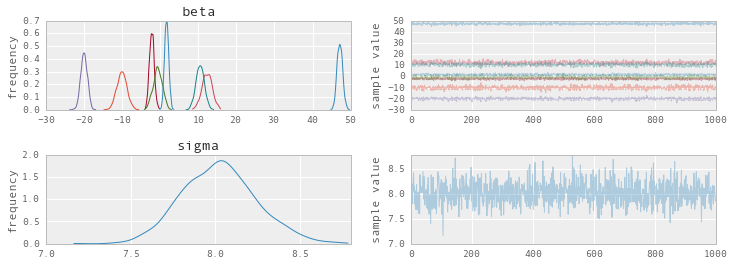

In [22]:
mdl_pooled_stan_fit.plot()
plt.show()

---

---

# Unpooled Model


Include the `mfr` feature values in the dmatrix. Each `mfr` value gets a separate intercept with shared slopes.


$$y \sim \mathcal{N}(\beta_{mfr} + \beta^{T} \bf{x},\epsilon)$$

where:  
$\beta_{mfr}$ is a separate intercept for each manufacturer  
$\beta$ are our (shared) coeffs in the linear model  
$\bf{x}$ is the vector of features describing each car in the dataset  
$\epsilon \sim \mathcal{HalfCauchy}(0, 10)$ 


Set priors as Cauchy(0, 2.5) as per Gelman 2008? 
http://www.stat.columbia.edu/~gelman/research/published/priors11.pdf

Nope, in later correspondance, he recommends Normals http://andrewgelman.com/2015/11/01/cauchy-priors-for-logistic-regression-coefficients/

Lots of other thoughts at: https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations


---

## PyMC3 Model

In [23]:
if sample_switches['unpooled']['pymc']:

    with pm.Model() as mdl_unpooled_pymc:

        run = OrderedDict()
        run['start'] = time()      
        
        b0 = pm.Normal('b0_mfr', mu=0, sd=10, shape=n_mfr)

        b1 = pm.Normal('b1_fuel_type[T.petrol]', mu=0, sd=10)
        b2a = pm.Normal('b2a_trans[T.manual]', mu=0, sd=10)
        b2b = pm.Normal('b2b_trans[T.semiauto]', mu=0, sd=10)
        b3 = pm.Normal('b3_is_tdi[T.True]', mu=0, sd=10)
        b4 = pm.Normal('b4_engine_capacity', mu=0, sd=10)
        b5 = pm.Normal('b5_metric_combined', mu=0, sd=10)
        b6 = pm.Normal('b6_emissions_co_mgkm', mu=0, sd=10)

        # define linear model
        yest = ( b0[dfs['mfr_enc']] +
                 b1 * mx_ex['fuel_type[T.petrol]'] + 
                 b2a * mx_ex['trans[T.manual]'] +
                 b2b * mx_ex['trans[T.semiauto]'] +
                 b3 * mx_ex['is_tdi[T.True]'] +
                 b4 * mx_ex['engine_capacity'] +
                 b5 * mx_ex['metric_combined'] +
                 b6 * mx_ex['emissions_co_mgkm'])

        ## Student T likelihood with HalfCauchy error and fixed DoF nu
        epsilon = pm.HalfCauchy('epsilon', beta=10)
        likelihood = pm.StudentT('likelihood', nu=1, mu=yest
                                 ,sd=epsilon, observed=dfs[ft_endog])

        run['build'] = time() 
        start_map = pm.find_MAP(fmin=optimize.fmin_powell)
        run['find_map'] = time()

        ## sample
        trc_unpooled_pymc = pm.sample(2000, njobs=2, step=pm.NUTS()
                            ,start=start_map
                            ,trace=pm.backends.Text('traces/trc_unpooled_pymc'))
        
        run['sample'] = time() 
    
    ## dump to disk
    write_pickle(obj=mdl_unpooled_pymc, relnm='models/mdl_unpooled_pymc.pkl')
    write_pickle(obj=run, relnm='models/mdl_unpooled_pymc_runtime.pkl')
    mdl_unpooled_pymc_run = run
    
else:  
    with pm.Model():   ## read from disk

        mdl_unpooled_pymc = read_pickle(relnm='models/mdl_unpooled_pymc.pkl')
        mdl_unpooled_pymc_run = read_pickle(relnm='models/mdl_unpooled_pymc_runtime.pkl')

    trc_unpooled_pymc = pm.backends.text.load('traces/trc_unpooled_pymc',
                                              model=mdl_unpooled_pymc)


Applied log-transform to epsilon and added transformed epsilon_log to model.
 [-----------------100%-----------------] 2001 of 2000 complete in 83.8 sec

##### Save WAIC and view traces

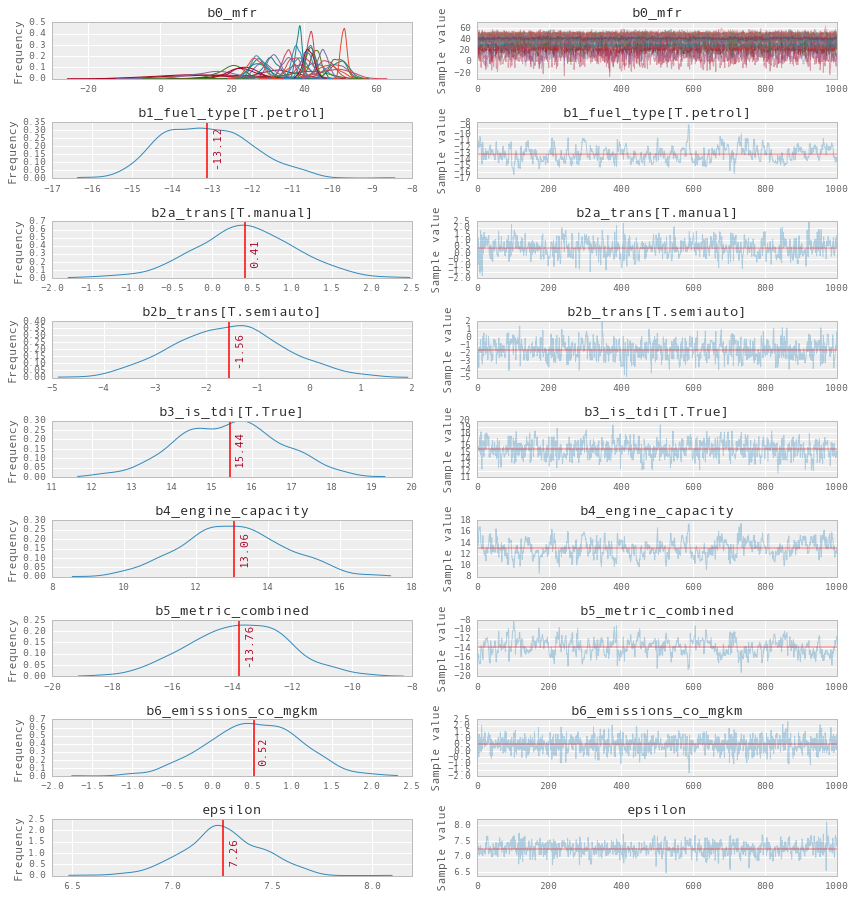

In [24]:
dfwaic_pymc['unpooled'] = [pm.stats.waic(model=mdl_unpooled_pymc,
                                         trace=trc_unpooled_pymc[-500:])]

rvs_unpooled_pymc = [rv.name for rv in strip_derived_rvs(mdl_unpooled_pymc.unobserved_RVs)]
plot_traces_pymc(trc_unpooled_pymc[-500:], varnames=rvs_unpooled_pymc)

---

## PyStan Model

##### Create model spec

In [25]:
mdl_unpooled_stan_spec = """

    /* Spec for unpooled regression linear model */

    data {                                 
        int<lower=0> N;                           // count of observations
        int<lower=0> K;                           // count of exog features
        matrix[N, K] X;                           // exog features
        vector[N] y;                              // endog feature
        int<lower=0> n_mfr;                   // count of mfr index levels
        int<lower=1,upper=n_mfr> mfr_enc[N];  // mfr index encoding  
    }
    parameters {
        vector[n_mfr] b0_mfr;                 // mfr intercept coeff
        vector[K] beta;                           // exog coeffs
        real<lower=0> sigma;                      // linear model error
    }
    transformed parameters {}
    model {  
        sigma ~ cauchy(0, 10);                    // prior for error
        y ~ student_t(1, b0_mfr[mfr_enc] + X * beta, sigma);  // student-T likelihood
    }
    generated quantities {}
"""

In [26]:
mdl_unpooled_stan_dict = {}
mdl_unpooled_stan_dict['N'] = mx_ex.iloc[:,1:].shape[0]
mdl_unpooled_stan_dict['K'] = mx_ex.iloc[:,1:].shape[1]
mdl_unpooled_stan_dict['X'] = mx_ex.iloc[:,1:].values
mdl_unpooled_stan_dict['y'] = mx_en[ft_endog].values

mdl_unpooled_stan_dict['mfr_enc'] = dfs['mfr_enc'].values + 1
mdl_unpooled_stan_dict['n_mfr'] = n_mfr

In [27]:
if sample_switches['unpooled']['stan']:

    run = OrderedDict()
    run['start'] = time()
    
    mdl_unpooled_stan_fit = pystan.stan(
            model_code  = mdl_unpooled_stan_spec,
            data        = mdl_unpooled_stan_dict,
            sample_file = ensure_dir('traces/trc_unpooled_stan/chain'),
            model_name  = 'mdl_unpooled_stan',
            iter        = 1000,
            warmup      = 750, 
            chains      = 4, 
            n_jobs      = 2, 
            verbose     = False)
    
    run['sample'] = time()
    
    # dump model object and model fit object to disk
    write_pickle(obj=mdl_unpooled_stan_fit.get_stanmodel(),
                 relnm='models/mdl_unpooled_stan_model.pkl')
    write_pickle(mdl_unpooled_stan_fit, 'models/mdl_unpooled_stan_fit.pkl')
    write_pickle(obj=run, relnm='models/mdl_unpooled_stan_runtime.pkl')
    mdl_unpooled_stan_run = run

else:      
    ## load the model first, and then the fit:
    mdl_unpooled_stan_model = read_pickle(relnm='models/mdl_unpooled_stan_model.pkl')
    mdl_unpooled_stan_fit = read_pickle(relnm='models/mdl_unpooled_stan_fit.pkl')
    mdl_unpooled_stan_run = read_pickle(relnm='models/mdl_unpooled_stan_runtime.pkl')

##### View fit

In [28]:
print(mdl_unpooled_stan_fit)

Inference for Stan model: mdl_unpooled_stan_a061e2f8c3b97303115009db09d70e90.
4 chains, each with iter=1000; warmup=750; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b0_mfr[0]   54.51    0.17   2.97  48.83  52.42  54.37   56.5  60.57    297    1.0
b0_mfr[1]    60.9    0.15   2.52  55.82  59.15  60.89  62.58  65.82    275    1.0
b0_mfr[2]   51.83    0.37   6.48  39.17  47.23  51.85  56.17  65.04    302    1.0
b0_mfr[3]   53.19    0.12    1.4   50.5  52.26  53.14  54.09  56.04    126   1.02
b0_mfr[4]   54.22    0.12   1.84  50.57  53.01  54.24  55.41   57.8    246    1.0
b0_mfr[5]   44.48    0.06   0.72  43.05  43.99  44.47  44.99  45.95    160   1.02
b0_mfr[6]   57.28    0.26   3.75  47.45   55.5  57.79  59.85  63.27    202   1.01
b0_mfr[7]   44.09     0.1    1.4  41.56  43.15  44.07  45.06  46.88    183   1.02
b0_mfr[8]   38.69    0.12   2.05  34.75  37.34  38.72  40.09  42.75 

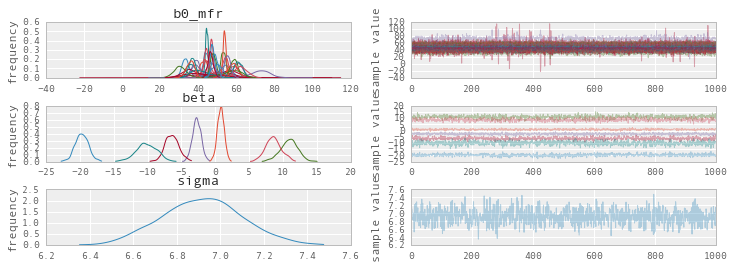

In [29]:
mdl_unpooled_stan_fit.plot()
plt.show()

---

## Evaluate Manufacturers using Unpooled Model

##### View forestplot of the `mfr` feature coeffs

In [30]:
dfsm_unpl_mfr = create_smry(trc_unpooled_pymc[-1000:], dfs, 'mfr')
sg_mfrfreq = dfs.groupby('mfr').size().reindex(dfsm_unpl_mfr.index)

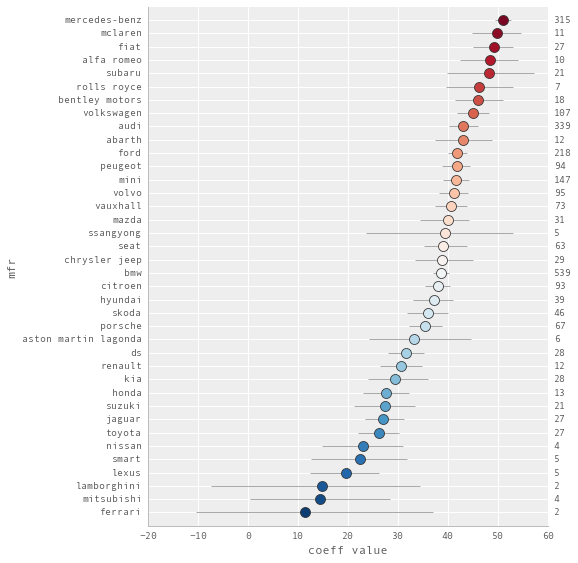

In [31]:
custom_forestplot(dfsm_unpl_mfr, sg_mfrfreq)

**Observe:**

The forestplot lets us compare the effect of `mfr` upon `emissions_nox_mgkm` when all other features in the mode are kept equal: `engine_capacity`, `fuel_type` etc etc

The forest plot shows:

+ The mean value for each parameter value, sorted in descending order
+ The uncertainty in each value, a.k.a. the Credible Region (CR) the region which the sample values spend X% of their time durng the traces. By convention I have chosen the 95% CR, but we could chose the 50% region or indeed anything that is useful for understanding.

Looking at the manufacturer values:

+ Mitsubuishi, seems to hang outside the pack by quite a long way
+ Jaguar and Lexus appear to emit least, however, you can see a weakness in this unpooled model, which is the massive uncertainty region for under-represented manufacturers

Under-representation is a problem:

+ Lamborghini and Lexus are represented in the dataset by 1 and 5 cars respectively and have massive CRs, so wide that we really can't say much about their effect upon emissions with certainty
+ Other manufacturers with few cars also have wide CRs: Mistubuishi (4), Ssangyong (5), Ferrari (2), Aston Martin Lagonda (6), and Smart (5)

We'll see later how this can be improved using partially-pooled model with a shared hyperparameter to 'share power' between the manufacturer parameters.

---

---

# Digression: Fully Unpooled Model


Of course, we can take this unpooling to an extreme, calculating separate intercepts and slopes for each manufacturer:

$$y \sim \mathcal{N}(\beta_{mfr}^{T} \bf{x},\epsilon)$$

where:  
$\beta_{mfr}$ are separate coeffs for each manufucturer
$\bf{x}$ is the vector of features describing each car in the dataset  
$\epsilon \sim \mathcal{HalfCauchy}(0, 10)$ 


---

## PyMC3 Model

In [32]:
if sample_switches['fullyunpooled']['pymc']:

    with pm.Model() as mdl_fullyunpooled_pymc:

        run = OrderedDict()
        run['start'] = time()
        
        b0 = pm.Normal('b0_mfr', mu=0, sd=10, shape=n_mfr)
        b1 = pm.Normal('b1_fuel_type[T.petrol]', mu=0, sd=10, shape=n_mfr)
        b2a = pm.Normal('b2a_trans[T.manual]', mu=0, sd=10, shape=n_mfr)
        b2b = pm.Normal('b2b_trans[T.semiauto]', mu=0, sd=10, shape=n_mfr)
        b3 = pm.Normal('b3_is_tdi[T.True]', mu=0, sd=10, shape=n_mfr)
        b4 = pm.Normal('b4_engine_capacity', mu=0, sd=10, shape=n_mfr)
        b5 = pm.Normal('b5_metric_combined', mu=0, sd=10, shape=n_mfr)
        b6 = pm.Normal('b6_emissions_co_mgkm', mu=0, sd=10, shape=n_mfr)

        # define linear model
        yest = ( b0[dfs['mfr_enc']] +
                 b1[dfs['mfr_enc']] * mx_ex['fuel_type[T.petrol]'] + 
                 b2a[dfs['mfr_enc']] * mx_ex['trans[T.manual]'] +
                 b2b[dfs['mfr_enc']] * mx_ex['trans[T.semiauto]'] +
                 b3[dfs['mfr_enc']] * mx_ex['is_tdi[T.True]'] +
                 b4[dfs['mfr_enc']] * mx_ex['engine_capacity'] +
                 b5[dfs['mfr_enc']] * mx_ex['metric_combined'] +
                 b6[dfs['mfr_enc']] * mx_ex['emissions_co_mgkm'])

        ## Student T likelihood with fixed degrees of freedom nu
        epsilon = pm.HalfCauchy('epsilon', beta=10)
        likelihood = pm.StudentT('likelihood', nu=1, mu=yest
                                 ,sd=epsilon, observed=dfs[ft_endog])
        
        run['build'] = time()
        start_map = pm.find_MAP(fmin=optimize.fmin_powell)   
        run['find_map'] = time()

        ## sample
        trc_fullyunpooled_pymc = pm.sample(2000, njobs=2, step=pm.NUTS()
                                ,start=start_map
                                ,trace=pm.backends.Text('traces/trc_fullyunpooled_pymc'))
        run['sample'] = time()

    ## dump to disk
    write_pickle(obj=mdl_fullyunpooled_pymc, relnm='models/mdl_fullyunpooled_pymc.pkl')
    write_pickle(obj=run, relnm='models/mdl_fullyunpooled_pymc_runtime.pkl')
    
else:
    with pm.Model():    ## read from disk

        mdl_fullyunpooled_pymc = read_pickle(relnm='models/mdl_fullyunpooled_pymc.pkl')
        mdl_fullyunpooled_pymc_run = read_pickle(relnm='models/mdl_fullyunpooled_pymc_runtime.pkl')

    trc_fullyunpooled_pymc = pm.backends.text.load('traces/trc_fullyunpooled_pymc',
                                                   model=mdl_fullyunpooled_pymc)


Applied log-transform to epsilon and added transformed epsilon_log to model.
 [-----------------100%-----------------] 2001 of 2000 complete in 1225.6 sec

##### View traces

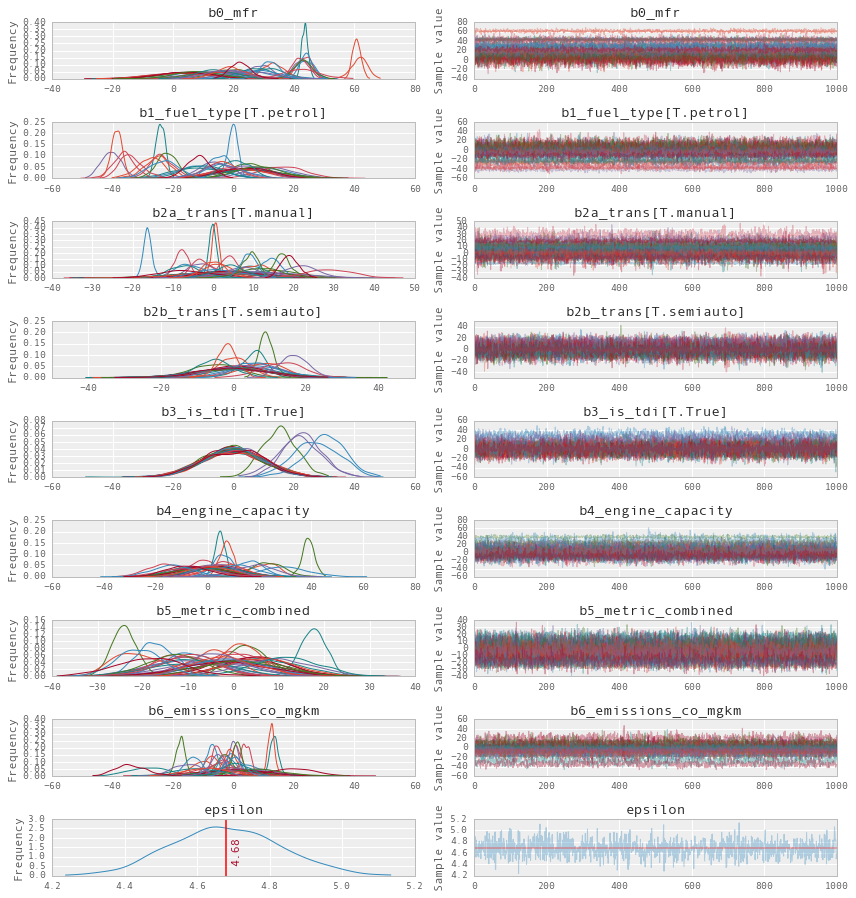

In [33]:
dfwaic_pymc['fullyunpooled'] = [pm.stats.waic(model=mdl_fullyunpooled_pymc,
                                         trace=trc_fullyunpooled_pymc[-500:])]
rvs_fullyunpooled_pymc = [rv.name for rv in \
                          strip_derived_rvs(mdl_fullyunpooled_pymc.unobserved_RVs)]
plot_traces_pymc(trc_fullyunpooled_pymc[-500:], varnames=rvs_fullyunpooled_pymc)

**Observe:**

There's three big issues with this fully unpooled model:

1. You'll notice I used the Metropolis sampler, rather than NUTS, because the NUTS sampler seemed to 'stall' and fail to move quickly around the posterior distribution - it sampled so slowly that it's unsuitable for this short demo.
2. Relatedly, the traces often show extreme values for parameters: likely because the separate values per manufacturer are simply allowed to vary too much and cause discontinuities in the posterior distribution.
3. Now, the differences between the manufacturers are captured across _all_ parameters in the mode, which makes comparing them really difficult! The mode may fit better (see the WAIC evaluation below), but we've made the task of human interpretation more difficult.

We have effectively fitted 38 seprate regressions, leading to immense complexity, slow sampling and messy traces. For this model at least, we need some degree of pooling.


**NOTE**: Regarding point 2 above: the slowness of NUTS sampling may possibly be something to do with the implementation in PyMC3, and I will look into this in future comparisons with Stan (via PyStan).

---

---

# Partially-Pooled Model

Here we place partial-pooling on intercept only: this hyperparameter lets us - in a balanced way - determine a difference between manufacturers `mfr` $m \in manufacturer$, keeping all other features constant

$$y \sim \mathcal{N}(\beta_{mfr} + \beta^{T} \bf{x}, \epsilon)$$

where (tree written upside down):  
$\beta_{mfr} \sim \mathcal{N}(\mu_{mfr}, \sigma_{mfr})$

$\;\;\;\;\;\;\;\;\;\;\;\;|\_\_ \mu_{mfr} \sim \mathcal{N}(0, 100) \;\;;\;\;
\sigma_{mfr} \sim \mathcal{HalfCauchy}(0, 10)$ 

$\beta$ are the other (shared) coeffs in the linear model  
$\bf{x}$ is the vector of features describing each car in the dataset  
$\epsilon \sim \mathcal{HalfCauchy}(0, 10)$ 

---

## PyMC3 Model

In [34]:
if sample_switches['partpooled']['pymc']:

    with pm.Model() as mdl_partpooled_pymc:

        run = OrderedDict()
        run['start'] = time()
        
        # define hyperpriors for intercept
        b0_mu = pm.Normal('b0_mu', mu=0, sd=10)
        b0_sd = pm.HalfCauchy('b0_sd', beta=10)

        # define priors
        b0 = pm.Normal('b0_mfr', mu=b0_mu, sd=b0_sd, shape=n_mfr)
        
        b1 = pm.Normal('b1_fuel_type[T.petrol]', mu=0, sd=10)
        b2a = pm.Normal('b2a_trans[T.manual]', mu=0, sd=10)
        b2b = pm.Normal('b2b_trans[T.semiauto]', mu=0, sd=10)
        b3 = pm.Normal('b3_is_tdi[T.True]', mu=0, sd=10)
        b4 = pm.Normal('b4_engine_capacity', mu=0, sd=10)
        b5 = pm.Normal('b5_metric_combined', mu=0, sd=10)
        b6 = pm.Normal('b6_emissions_co_mgkm', mu=0, sd=10)

        # define linear model
        yest = ( b0[dfs['mfr_enc']] +
                 b1 * mx_ex['fuel_type[T.petrol]'] + 
                 b2a * mx_ex['trans[T.manual]'] +
                 b2b * mx_ex['trans[T.semiauto]'] +
                 b3 * mx_ex['is_tdi[T.True]'] +
                 b4 * mx_ex['engine_capacity'] +
                 b5 * mx_ex['metric_combined'] +
                 b6 * mx_ex['emissions_co_mgkm'])

        ## Student T likelihood with fixed degrees of freedom nu
        epsilon = pm.HalfCauchy('epsilon', beta=10)
        likelihood = pm.StudentT('likelihood', nu=1, mu=yest
                                 ,sd=epsilon, observed=dfs[ft_endog])

        run['build'] = time()
        start_map = pm.find_MAP(fmin=optimize.fmin_powell)
        run['find_map'] = time()        
        
        ## sample
        trc_partpooled_pymc = pm.sample(2000, njobs=2, step=pm.NUTS(),
                                start=start_map,
                                trace=pm.backends.Text('traces/trc_partpooled_pymc'))
        run['sample'] = time()        
        
    ## dump to disk
    write_pickle(obj=mdl_partpooled_pymc, relnm='models/mdl_partpooled_pymc.pkl')
    write_pickle(obj=run, relnm='models/mdl_partpooled_pymc_runtime.pkl')
    mdl_partpooled_pymc_run = run
    
else:
    with pm.Model():   ## read from disk

        mdl_partpooled_pymc = read_pickle(relnm='models/mdl_partpooled_pymc.pkl')
        mdl_partpooled_pymc_run = read_pickle(relnm='models/mdl_partpooled_pymc_runtime.pkl')

    trc_partpooled_pymc = pm.backends.text.load('traces/trc_partpooled_pymc',
                                                   model=mdl_partpooled_pymc)
    

Applied log-transform to b0_sd and added transformed b0_sd_log to model.
Applied log-transform to epsilon and added transformed epsilon_log to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 82.6 sec

##### Save WAIC and View traces

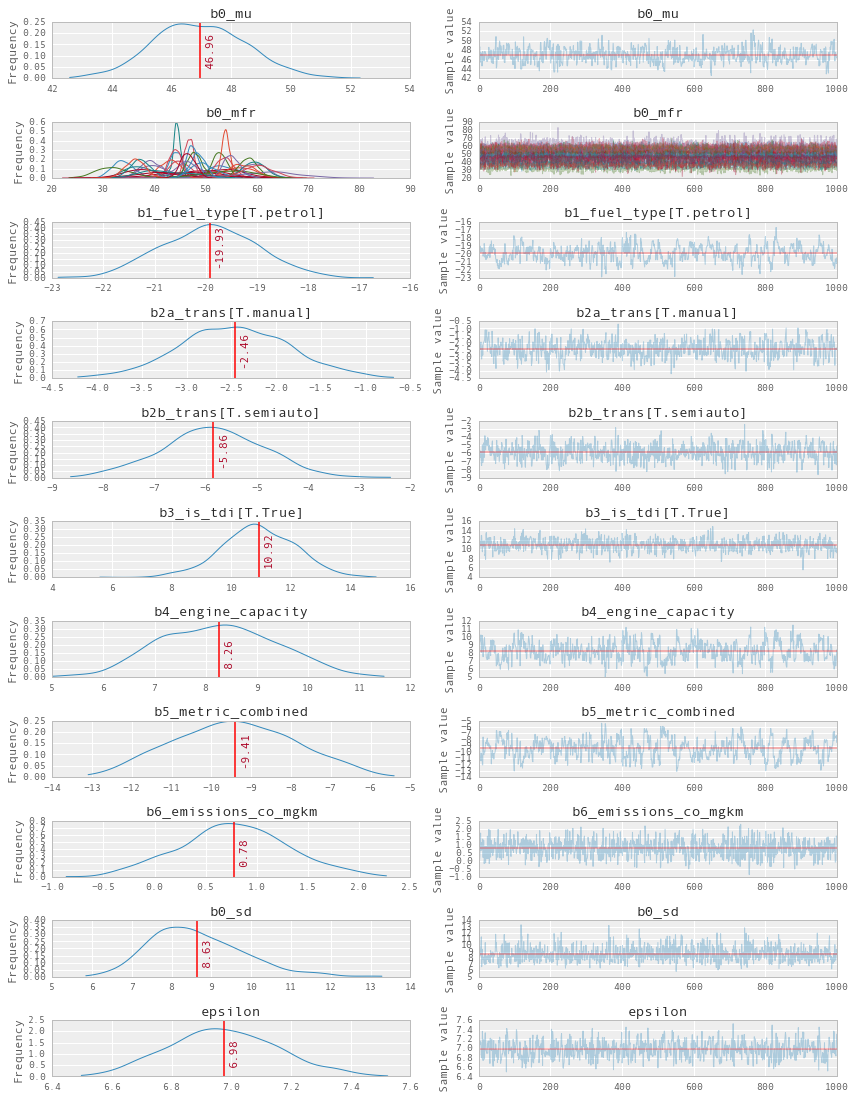

In [35]:
dfwaic_pymc['partpooled'] = [pm.stats.waic(model=mdl_partpooled_pymc,
                                         trace=trc_partpooled_pymc[-500:])]
rvs_partpooled_pymc = [rv.name for rv in \
                          strip_derived_rvs(mdl_partpooled_pymc.unobserved_RVs)]
plot_traces_pymc(trc_partpooled_pymc[-500:], varnames=rvs_partpooled_pymc)

**Observe:**

This is more like it:

+ The traceplots look pretty well-mixed
+ We have a shared mean for the intercept `b0_mu` at approx. 48.
+ All the 38 `mfr` values are located around this value, with standard deviation `b0_sd`: as we see in the plot for `b0_mfr`

---

## PyStan Model

In [36]:
mdl_partpooled_stan_spec = """

    /* Spec for partpooled regression linear model */

    data {                                 
        int<lower=0> N;                         // count of observations
        int<lower=0> K;                         // count of exog features
        matrix[N, K] X;                         // exog features
        vector[N] y;                            // endog feature
        int<lower=0> n_mfr;                     // count of mfr index levels
        int<lower=1, upper=n_mfr> mfr_enc[N];   // mfr index encoding  
    }
    parameters {
        vector[K] beta;                         // exog coeffs
        real<lower=0> sigma;                    // linear model error       

        real mfr_mu;                            // part-pooling prior mu
        real<lower=0> mfr_sd;                   // part-pooling prior sd    
        vector[n_mfr] b0_mfr;                   // mfr intercept coeff
    }
    transformed parameters {}
    model {  
        
        mfr_mu ~ normal(0, 10);                  // part-pooling prior mu
        mfr_sd ~ cauchy(0, 10);                  // part-pooling prior sd
     
        for (mfr in 1:n_mfr) {
              b0_mfr[mfr] ~ normal(mfr_mu, mfr_sd);
        }
    
        sigma ~ cauchy(0, 10);                    // prior for error
        y ~ student_t(1, b0_mfr[mfr_enc] + X * beta, sigma);  // student-T likelihood
    }
    generated quantities {}
"""

In [37]:
if sample_switches['partpooled']['stan']:

    run = OrderedDict()
    run['start'] = time()

    mdl_partpooled_stan_fit = pystan.stan(
            model_code  = mdl_partpooled_stan_spec,
            data        = mdl_unpooled_stan_dict,
            sample_file = ensure_dir('traces/trc_partpooled_stan/chain'),
            model_name  = 'mdl_partpooled_stan',
            iter        = 1000,
            warmup      = 750, 
            chains      = 4, 
            n_jobs      = 2, 
            verbose     = False)

    run['sample'] = time()
    
    # dump model object and model fit object to disk
    write_pickle(obj=mdl_partpooled_stan_fit.get_stanmodel(),
                 relnm='models/mdl_partpooled_stan_model.pkl')
    write_pickle(mdl_partpooled_stan_fit, 'models/mdl_partpooled_stan_fit.pkl')
    write_pickle(obj=run, relnm='models/mdl_partpooled_stan_runtime.pkl')
    mdl_partpooled_stan_run = run
    
else:      
    ## load the model first, and then the fit:
    mdl_partpooled_stan_model = read_pickle(relnm='models/mdl_partpooled_stan_model.pkl')
    mdl_partpooled_stan_fit = read_pickle(relnm='models/mdl_partpooled_stan_fit.pkl')
    mdl_partpooled_stan_run = read_pickle(relnm='models/mdl_partpooled_stan_runtime.pkl')

##### View summary

In [38]:
print(mdl_partpooled_stan_fit)

Inference for Stan model: mdl_partpooled_stan_84085e84ce57e47d7eaa8c803400591d.
4 chains, each with iter=1000; warmup=750; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0]    -19.92    0.08   0.94 -21.74  -20.5  -19.9 -19.34 -17.99    128   1.02
beta[1]     -2.56    0.04   0.61  -3.68  -2.98  -2.57  -2.15  -1.37    209   1.01
beta[2]     -5.97    0.07   0.98  -7.88   -6.6  -6.01  -5.39  -3.89    222    1.0
beta[3]     11.12    0.08   1.24   8.69  10.24  11.13   12.0  13.45    228   1.01
beta[4]      8.36    0.09   1.14   6.19    7.6   8.29   9.12   10.6    174   1.01
beta[5]     -9.57    0.12   1.47 -12.59 -10.52  -9.53  -8.57   -6.9    148   1.02
beta[6]      0.84    0.03   0.49  -0.07   0.51   0.85   1.15   1.78    310    1.0
sigma        6.96    0.01   0.19    6.6   6.82   6.96   7.09   7.33    323    1.0
mfr_mu      46.95     0.1   1.63  43.76  45.86  46.95  48.03  50.1

##### View traces

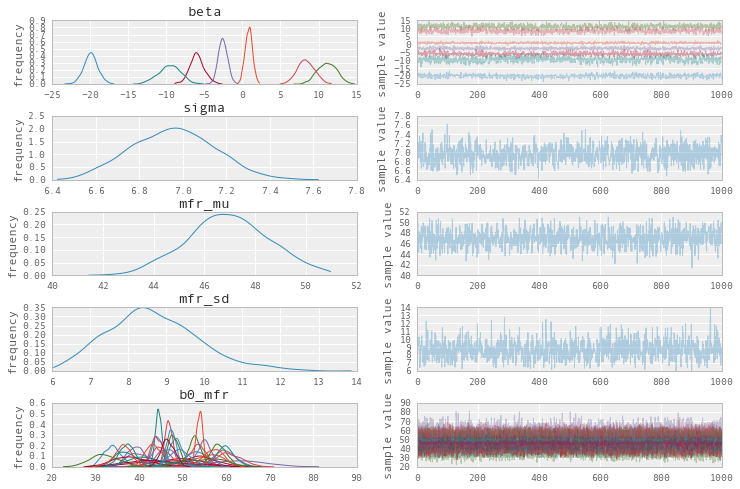

In [39]:
f = mdl_partpooled_stan_fit.plot()
f.set_size_inches(12, 8)
plt.show()

### Compare PyStan model coeffs to PyMC3 coeffs

In [40]:
# return a dictionary of arrays
samples = mdl_partpooled_stan_fit.extract(permuted=True)
for k, v in samples.items():
    print(k, v.shape)

beta (1000, 7)
sigma (1000,)
mfr_mu (1000,)
mfr_sd (1000,)
b0_mfr (1000, 38)
lp__ (1000,)


In [41]:
pd.DataFrame(samples['beta'], columns=mx_ex.columns[1:]).describe().T

,count,mean,std,min,25%,50%,75%,max
fuel_type[T.petrol],1000.0,-19.917704,0.937931,-23.356087,-20.498154,-19.904352,-19.341570,-16.919466
trans[T.manual],1000.0,-2.559103,0.610810,-4.829840,-2.979400,-2.574975,-2.150368,-0.533342
trans[T.semiauto],1000.0,-5.967450,0.976386,-8.892915,-6.598331,-6.013942,-5.394773,-2.646633
is_tdi[T.True],1000.0,11.123382,1.235563,6.746645,10.237957,11.126357,11.994976,14.733796
engine_capacity,1000.0,8.362623,1.136453,4.937587,7.596002,8.287455,9.118037,11.672196
metric_combined,1000.0,-9.573854,1.466049,-14.336753,-10.515532,-9.526050,-8.568310,-5.064972
emissions_co_mgkm,1000.0,0.838372,0.485223,-0.548203,0.512813,0.853112,1.152186,2.241507


##### Compare to PyMC3

In [42]:
pm.df_summary(trc_partpooled_pymc[-500:], varnames=rvs_partpooled_pymc).iloc[-9:-2,:]

,mean,sd,mc_error,hpd_2.5,hpd_97.5
b1_fuel_type[T.petrol],-19.925018,0.932160,0.063483,-21.675219,-18.108640
b2a_trans[T.manual],-2.463633,0.595028,0.029100,-3.660509,-1.339570
b2b_trans[T.semiauto],-5.855634,0.983462,0.043231,-7.920005,-4.088734
b3_is_tdi[T.True],10.921362,1.236312,0.051299,8.492571,13.385555
b4_engine_capacity,8.257231,1.130576,0.074537,6.182187,10.312189
b5_metric_combined,-9.411610,1.502116,0.106943,-12.228465,-6.566172
b6_emissions_co_mgkm,0.780377,0.522591,0.015058,-0.234866,1.815467


> Looks similar!

---

## Evaluate Manufacturers using Partially-Pooled PyMC3 Model

Compare the forestplot for this partpooled model with that of the unpooled model to see shrinkage

In [43]:
dfsm_ptpl_mfr = create_smry(trc_partpooled_pymc[-500:], dfs, 'mfr')

In [44]:
dfsm_mfr_vs = pd.concat((dfsm_ptpl_mfr
                         ,dfsm_unpl_mfr.reindex(dfsm_ptpl_mfr.index)), axis=0)
dfsm_mfr_vs['mdl'] = np.concatenate(
                    (np.repeat(['partpooled'],38), np.repeat('unpooled',38)))
dfsm_mfr_vs.iloc[38:]['ypos'] = dfsm_mfr_vs.iloc[:38]['ypos']

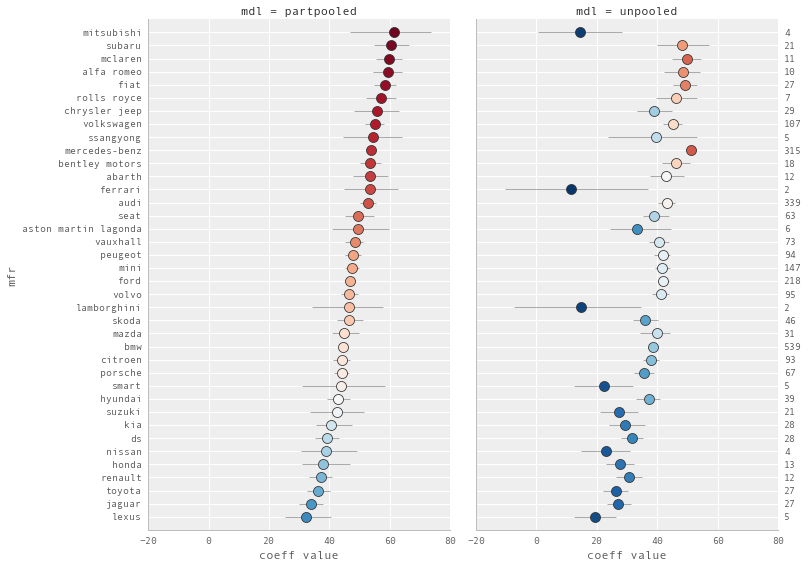

In [45]:
custom_forestplot(dfsm_mfr_vs, sg_mfrfreq, aspect=0.6, facetby='mdl')

**Observe:**

+ The forestplot for the `partpooled` model is shown on the left and the `unpooled` is on the right. Note the rows are ordered according to the `partpooled` model.
+ There's a few small changes in ordering from the `unpooled` model, for instance: Ssangyong, Mercedes-Benz, Ferrari
+ There's a noticable reduction in uncertainty for some parameters which have low counts, for instance: Lamborghini (1 car), Lexus (5 cars) and Smart (5 cars)

**Shrinkage**

Overall all the parameters appear to be pulled in slightly closer together, this is a.k.a 'shrinkage'
+ The coeffs now occupy a region between 34 - 62, centered on approx 50. This compares to the unpooled model where parameters have a region between 32 and 72. 
+ This reduction in variance would suggest the `partpooled` model is less overfitted than the `unpooled`, and may perform better in hold-out validation.



---

## Can we comment on Volkswagen's NOx emissions at `mfr` level?

We can see from the above that the intercept parameter for `mfr == volkswagen` is 8th highest in the pack of all 38 manufacturers, seemingly higher than average.

Let's take a more detailled look at the parameter value compared to the group mean

In [46]:
## Summary of Volkswagen
dfsm_ptpl_mfr.loc[['volkswagen']]

,featval,mean,sd,mc_error,hpd_2.5,hpd_97.5,ypos
volkswagen,b0_mfr__36,55.068179,1.620809,0.084683,51.764981,58.088839,30


In [47]:
## Hyperprior group mean and standard dev
pm.df_summary(trc_partpooled_pymc[-500:], varnames=['b0_mu','b0_sd'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5
b0_mu,46.955981,1.533542,0.080715,44.183611,50.131024
b0_sd,8.631901,1.159616,0.040031,6.398189,10.838418


**Observe:**

The model is specified such that all 38 `mfr` parameters share a common hyperparameter `b0_mu` for their mean, and common hyperparameter `b0_sd` for their standard deviation.

+ Looking at the **mean**:  
Volkswagen has a mean value of `55.32` with a 95% CR from `52.12 to 58.15`  
The group mean `b0_mn` has a mean value much lower at `48.15` with a 95% CR from `44.76 to 51.80`  
The 95% CR for Volkswagen does not overlap with the 95% CR for the group mean, so we can say that it is strongly above the mean for NOx emissions.


+ Looking at the **standard deviation**:  
Volkswagen has a sd value of `1.60`   
The group sd `b0_sd` has a mean value much higher at `8.71` with a 95% CR from `6.34 to 10.99`  
The sd for Volkswagen does not overlap with the 95% CR for the group sd, so we can say that Volkswagen has a strongly narrow distribution in its mean NOx emissions.


+ **In summary**  it seems that Volkswagen has an unusually high and tight parameter explaining their NOx emissions.



**Caveat: This is far from rigorous!**  

1. The manufacturer parameter values are all quite well distributed through a large range `34 to 62` and don't always overlap with one another. We can make the same inference of 'tightly above average NOx emissions' for several other manufacturers: Rolls Royce, Fiat, Alfa Romeo, Maclaren and Subaru.
2. We haven't considered the manufacturer-owner parameter `mfr_owner`: which is higher-level information and may help with the class imbalances on `mfr`

---

---

# Hierarchical Model of Parent and Manufacturer

Now's the time to consider it: because the parent company may provide important information. 

$$y \sim \mathcal{N}(\beta_{mfr} + \beta^{T} \bf{x}, \epsilon)$$

where (tree written upside down):  
$\beta_{mfr} \sim \mathcal{N}(\mu_{mfr}, \sigma_{mfr})$

$\;\;\;\;|\_\_ \mu_{mfr} \sim \mathcal{N}(\mu_{parent}, \sigma_{parent}) \;\; ; \;\;
\sigma_{mfr} \sim \mathcal{HalfCauchy}(0, 10)$ 

$\;\;\;\;\;\;\;\;\;\;|\_\_  \mu_{parent} \sim \mathcal{N}(0, 10) \;\; ; \;\; \sigma_{parent}\sim \mathcal{HalfCauchy}(0, 10)$  


$\beta$ are the other (shared) coeffs in the linear model  
$\bf{x}$ is the vector of features describing each car in the dataset  
$\epsilon \sim \mathcal{HalfCauchy}(0, 10)$ 

Since I wanted to build the case slowly, I've not yet considered `parent`: the manufacturer parent company.

Now's the time to consider it: because the parent company may provide important information. 

We could create another part-pooled model like above, with `parent` as a separate set of parameter coeffs, but quite obviously the `mfr` correolates completely with `parent` in a hierarchical structure; we can't assume orthogonality in the model.

Rather than have all `mfr`s joined by a single hyperparameter, let's instead join them to a hyperparameter set by their parent company `parent`. These 20 `parent` levels will in turn be joined to a single hyperparameter. It's just an extension of the part-pooling model to create a truely hierarchical model which incorporates the ownership structure we know about. 

In [48]:
mfr_parent_map = (dfs.groupby(['mfr_enc','parent_enc']).size()
                  .reset_index()['parent_enc'].values)
mfr_parent_map

array([ 3,  3,  0, 19, 19,  1,  3, 12, 12,  3,  3,  4,  7,  8, 17,  8, 19,
       18,  9, 10,  2,  1, 11, 13, 12, 19, 13,  1, 19, 19,  2, 14, 15, 16,
       18,  6, 19,  5])

---

## PyMC3 Model

In [49]:
if sample_switches['hier']['pymc']:

    run = OrderedDict()
    run['start'] = time()
    
    with pm.Model() as mdl_hier_pymc:

        # define hyperpriors for intercept based on parent       # 1x 
        b0_parent_mn = pm.Normal('b0_parent_mn', mu=0, sd=10)
        b0_parent_sd = pm.HalfCauchy('b0_parent_sd', beta=10)

        # define hyperpriors for mfr based on parent            # 20x
        b0_parent = pm.Normal('b0_parent', mu=b0_parent_mn,
                              sd=b0_parent_sd, shape=n_parent)
        b0_mfr_sd = pm.HalfCauchy('b0_mfr_sd', beta=10)

        # define priors
        b0 = pm.Normal('b0_mfr', mu=b0_parent[mfr_parent_map],  
                        sd=b0_mfr_sd, shape=n_mfr)               # 38x

        b1 = pm.Normal('b1_fuel_type[T.petrol]', mu=0, sd=10)
        b2a = pm.Normal('b2a_trans[T.manual]', mu=0, sd=10)
        b2b = pm.Normal('b2b_trans[T.semiauto]', mu=0, sd=10)
        b3 = pm.Normal('b3_is_tdi[T.True]', mu=0, sd=10)
        b4 = pm.Normal('b4_engine_capacity', mu=0, sd=10)
        b5 = pm.Normal('b5_metric_combined', mu=0, sd=10)
        b6 = pm.Normal('b6_emissions_co_mgkm', mu=0, sd=10)
                             
        # define hierachical linear model
        yest = ( b0[dfs['mfr_enc']] +
                 b1 * mx_ex['fuel_type[T.petrol]'] + 
                 b2a * mx_ex['trans[T.manual]'] +
                 b2b * mx_ex['trans[T.semiauto]'] +
                 b3 * mx_ex['is_tdi[T.True]'] +
                 b4 * mx_ex['engine_capacity'] +
                 b5 * mx_ex['metric_combined'] +
                 b6 * mx_ex['emissions_co_mgkm'])

        ## StudentT likelihood with fixed degrees of freedom nu
        epsilon = pm.HalfCauchy('epsilon', beta=10)
        likelihood = pm.StudentT('likelihood', nu=1, mu=yest
                                 ,sd=epsilon, observed=dfs[ft_endog])

        run['build'] = time()
        
        # start_map = pm.find_MAP(fmin=optimize.fmin_powell)  ## takes a LONG time
        # run['find_map'] = time()
               
        ## sample
        trc_hier_pymc = pm.sample(2000, njobs=2, step=pm.NUTS()
                               #,start=start_map
                               ,trace=pm.backends.Text('traces/trc_hier_pymc'))

        run['sample'] = time()
        
    ## dump to disk
    write_pickle(obj=mdl_hier_pymc, relnm='models/mdl_hier_pymc.pkl')
    write_pickle(obj=run, relnm='models/mdl_hier_pymc_runtime.pkl')
    mdl_hier_pymc_run = run
    

else:
    with pm.Model():   ## read from disk

        mdl_hier_pymc = read_pickle(relnm='models/mdl_hier_pymc.pkl')
        mdl_hier_pymc_run = read_pickle(relnm='models/mdl_hier_pymc_runtime.pkl')

    trc_hier_pymc = pm.backends.text.load('traces/trc_hier_pymc',
                                          model=mdl_hier_pymc)

Applied log-transform to b0_parent_sd and added transformed b0_parent_sd_log to model.
Applied log-transform to b0_mfr_sd and added transformed b0_mfr_sd_log to model.
Applied log-transform to epsilon and added transformed epsilon_log to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 122.7 sec

##### Save WAIC and view traceplots

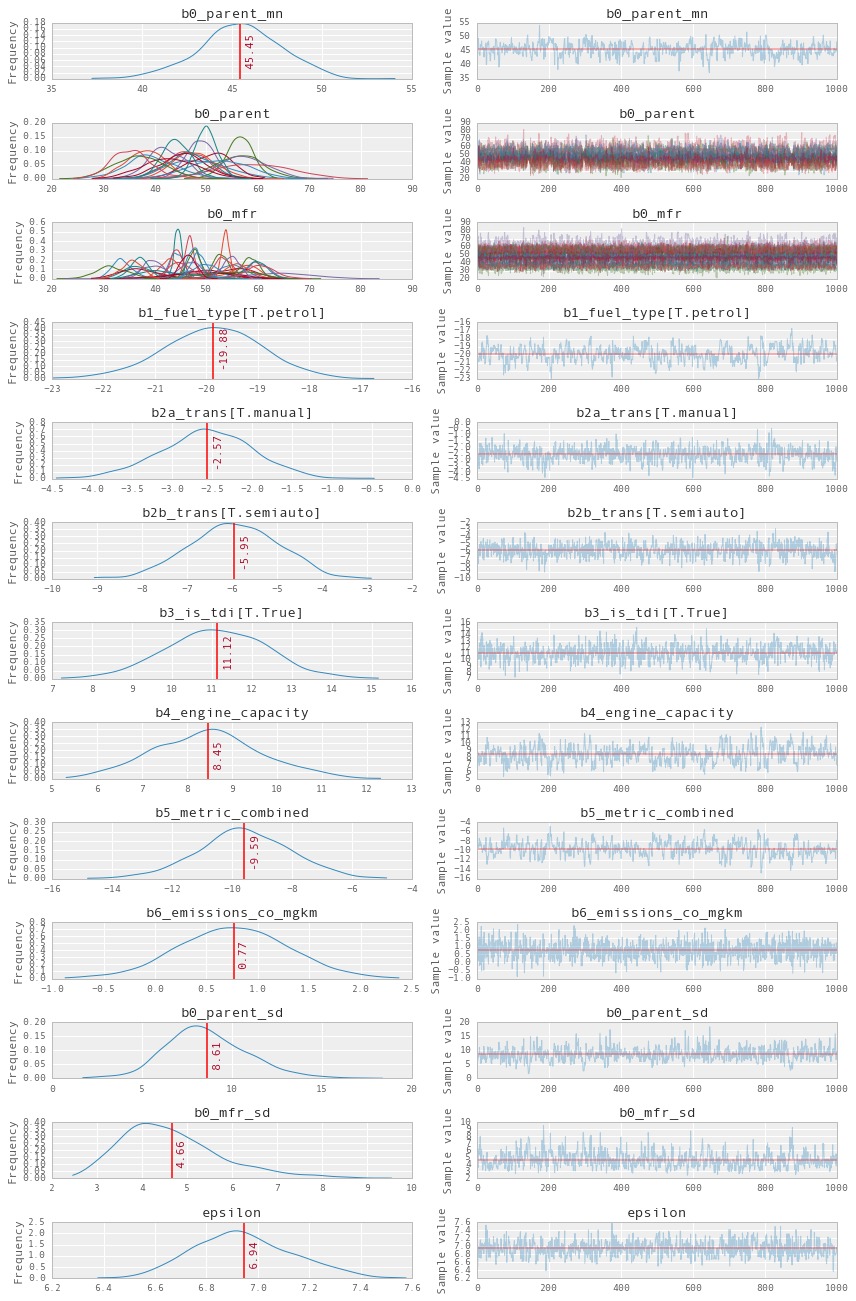

In [50]:
dfwaic_pymc['hier'] = [pm.stats.waic(model=mdl_hier_pymc,
                                         trace=trc_hier_pymc[-500:])]
rvs_hier_pymc = [rv.name for rv in strip_derived_rvs(mdl_hier_pymc.unobserved_RVs)]
plot_traces_pymc(trc_hier_pymc[-500:], varnames=rvs_hier_pymc)

---

## PyStan Model

In [51]:
mdl_hier_stan_spec = """

    /* Spec for hierarchical regression linear model */

    data {                                 
        int<lower=0> N;                         // count of observations
        int<lower=0> K;                         // count of exog features
        matrix[N, K] X;                         // exog features
        vector[N] y;                            // endog feature

        int<lower=0> n_parent;                      // count of parent index levels
        int<lower=1, upper=n_parent> parent_enc[N]; // parent index encoding  
        
        int<lower=0> n_mfr;                     // count of mfr index levels
        int<lower=1, upper=n_mfr> mfr_enc[N];   // mfr index encoding          
        
        int<lower=1, upper=n_mfr> mfr_parent_map[n_mfr];
    }
    parameters {
        vector[K] beta;                         // exog coeffs
        real<lower=0> sigma;                    // linear model error       

        real parent_mu;                         // parent mu hyperprior
        real<lower=0> parent_sd;                // parent sd hyperprior

        vector [n_parent] b0_parent;            // mfr mu hyperprior (parent prior)
        real<lower=0> mfr_sd;                   // mfr sd hyperprior

        vector[n_mfr] b0_mfr;                   // mfr prior
    }
    transformed parameters {}
    model {  
        
        parent_mu ~ normal(0, 10);              // weakly informative
        parent_sd ~ cauchy(0, 10);              // weakly informative
        mfr_sd ~ cauchy(0, 10);                 // weakly informative
        
                  
        for (parent in 1:n_parent) {            // parent priors (20x)
              b0_parent[parent] ~ normal(parent_mu, parent_sd);
        }

        for (mfr in 1:n_mfr) {                  // mfr priors (38x)
            b0_mfr[mfr] ~ normal(b0_parent[mfr_parent_map[mfr]], mfr_sd);
        }      

        sigma ~ cauchy(0, 10);                  // weakly informative noise
        y ~ student_t(1, b0_mfr[mfr_enc] + X * beta, sigma);    // likelihood
    }
    
"""

In [52]:
mdl_hier_stan_dict = {}
mdl_hier_stan_dict['N'] = mx_ex.iloc[:,1:].shape[0]
mdl_hier_stan_dict['K'] = mx_ex.iloc[:,1:].shape[1]
mdl_hier_stan_dict['X'] = mx_ex.iloc[:,1:].values
mdl_hier_stan_dict['y'] = mx_en[ft_endog].values

mdl_hier_stan_dict['parent_enc'] = dfs['parent_enc'].values + 1
mdl_hier_stan_dict['n_parent'] = n_parent
mdl_hier_stan_dict['mfr_enc'] = dfs['mfr_enc'].values + 1
mdl_hier_stan_dict['n_mfr'] = n_mfr

mdl_hier_stan_dict['mfr_parent_map'] = mfr_parent_map + 1

In [53]:
if sample_switches['hier']['stan']:

    run = OrderedDict()
    run['start'] = time()
    
    mdl_hier_stan_fit = pystan.stan(
            model_code  = mdl_hier_stan_spec,
            data        = mdl_hier_stan_dict,
            sample_file = ensure_dir('traces/trc_hier_stan/chain'),
            model_name  = 'mdl_hier_stan',
            iter        = 1000,
            warmup      = 750, 
            chains      = 4, 
            n_jobs      = 2, 
            verbose     = False)

    run['sample'] = time()
    
    # dump model object and model fit object to disk
    write_pickle(obj=mdl_hier_stan_fit.get_stanmodel(),
                 relnm='models/mdl_hier_stan_model.pkl')
    write_pickle(mdl_hier_stan_fit, 'models/mdl_hier_stan_fit.pkl')
    write_pickle(obj=run, relnm='models/mdl_hier_stan_runtime.pkl')
    mdl_hier_stan_run = run
    
else:      
    ## load the model first, and then the fit:
    mdl_hier_stan_model = read_pickle(relnm='models/mdl_hier_stan_model.pkl')
    mdl_hier_stan_fit = read_pickle(relnm='models/mdl_hier_stan_fit.pkl')
    mdl_hier_stan_run = read_pickle(relnm='models/mdl_hier_stan_runtime.pkl')

##### View summary

In [54]:
print(mdl_hier_stan_fit)

Inference for Stan model: mdl_hier_stan_a3afdaeb2a58ed9385e29e1b7942f47f.
4 chains, each with iter=1000; warmup=750; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0]       -19.73    0.07    0.9 -21.44 -20.34 -19.75 -19.13 -17.89    152   1.03
beta[1]        -2.56    0.04   0.59  -3.75  -2.95  -2.57  -2.16  -1.38    190    1.0
beta[2]        -5.98    0.06   0.97  -7.89  -6.64   -6.0   -5.3  -4.08    231    1.0
beta[3]        11.26    0.08   1.23   8.83  10.48  11.27  12.11  13.69    232   1.01
beta[4]          8.7    0.07   1.09   6.56   7.95   8.68   9.44  10.98    228    1.0
beta[5]         -9.9     0.1    1.4 -12.87 -10.81  -9.87  -8.98  -7.13    195   1.01
beta[6]          0.8    0.03   0.52  -0.21   0.43    0.8   1.17   1.83    312    1.0
sigma           6.95    0.01   0.19    6.6   6.83   6.96   7.07   7.32    334    1.0
parent_mu       45.3    0.15   2.33  40.69  4

##### View traces

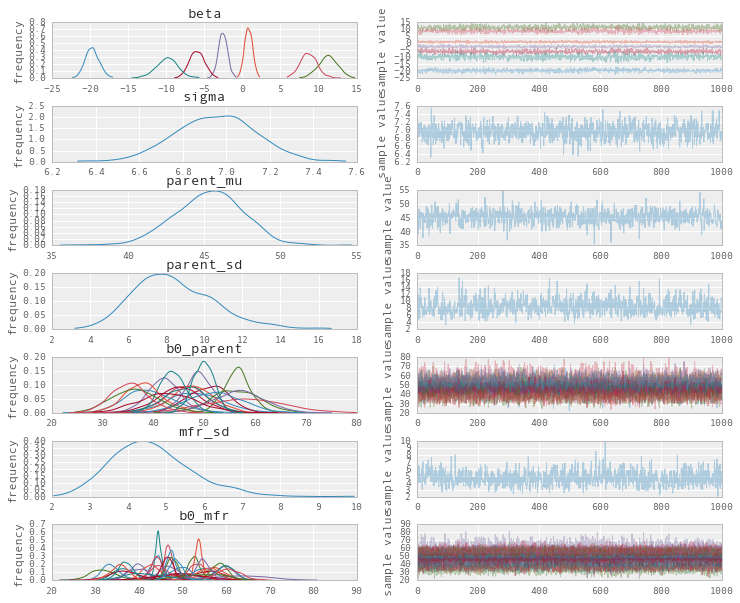

In [55]:
f = mdl_hier_stan_fit.plot()
f.set_size_inches(12, 10)
plt.show()

---

---

# Model Runtimes

How do they compare?

In [56]:
sampletimes_pymc, sampletimes_stan = [], []
runs_pymc = [mdl_pooled_pymc_run, mdl_unpooled_pymc_run,
             mdl_partpooled_pymc_run, mdl_hier_pymc_run]
runs_stan = [mdl_pooled_stan_run, mdl_unpooled_stan_run,
             mdl_partpooled_stan_run, mdl_hier_stan_run]

for run in runs_pymc:
    sampletimes_pymc.append(np.diff(np.array([v for v in run.values()]))[-1])
    
for run in runs_stan:
    sampletimes_stan.append(np.diff(np.array([v for v in run.values()]))[-1])

In [57]:
dfrun = pd.DataFrame({'mdl':['pooled', 'unpooled', 'partpooled', 'hier'],
                      'pymc':sampletimes_pymc, 'stan':sampletimes_stan})
dfrun = pd.melt(dfrun, id_vars='mdl', var_name='framework', value_name='duration')

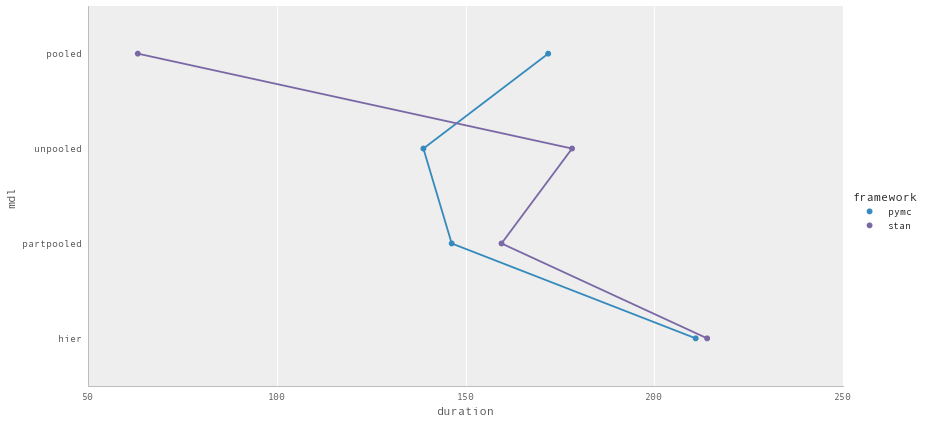

In [58]:
g = sns.factorplot(x='duration', y='mdl', hue='framework', data=dfrun,
              kind='point', join=True, size=6, aspect=2, scatter_kws={'ms':200})

---

---

# Inferences on mfr and parent

## Evaluate manufacturer using the hier model

##### Compare to unpooled and partpooled models

In [59]:
dfsm_hier_mfr = create_smry(trc_hier_pymc[-333:], dfs, 'mfr')

In [60]:
dfsm_mfr_vs = pd.concat((dfsm_hier_mfr
                         ,dfsm_ptpl_mfr.reindex(dfsm_hier_mfr.index)
                         ,dfsm_unpl_mfr.reindex(dfsm_hier_mfr.index)), axis=0)
dfsm_mfr_vs['mdl'] = np.concatenate(
        (np.repeat(['hier'],38), np.repeat(['partpooled'],38), np.repeat(['unpooled'],38)))
dfsm_mfr_vs.iloc[38:]['ypos'] = dfsm_mfr_vs.iloc[:38]['ypos']
dfsm_mfr_vs.iloc[2*38:]['ypos'] = dfsm_mfr_vs.iloc[:38]['ypos']

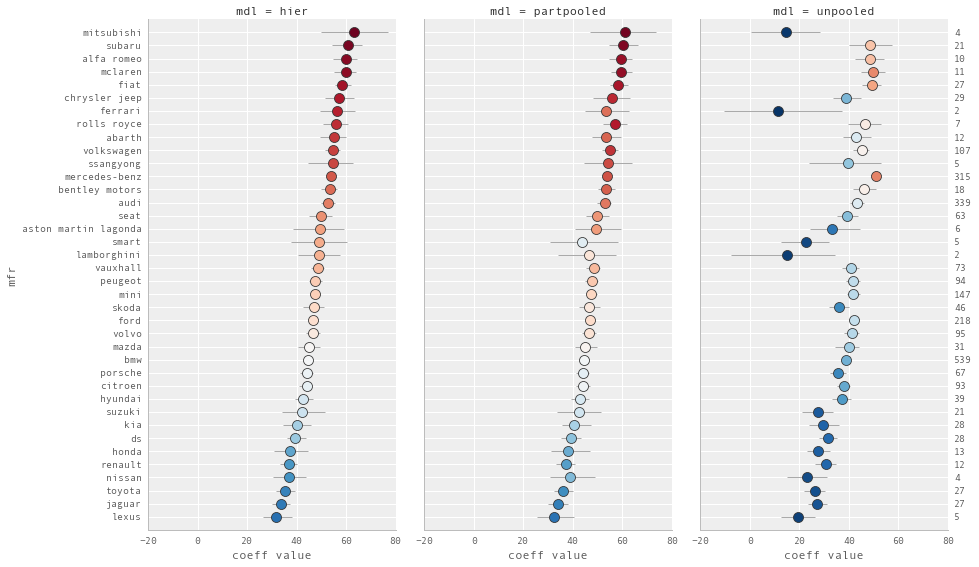

In [61]:
custom_forestplot(dfsm_mfr_vs, sg_mfrfreq, aspect=0.5, facetby='mdl')

---

## Evaluate parent using the hier model

In [62]:
dfsm_hier_parent = create_smry(trc_hier_pymc[-500:], dfs, 'parent')
sg_parentfreq = dfs.groupby('parent').size().reindex(dfsm_hier_parent.index)

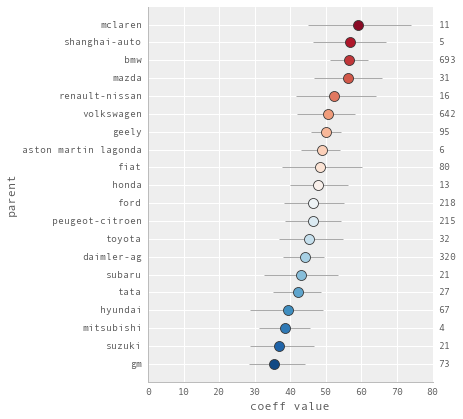

In [63]:
custom_forestplot(dfsm_hier_parent, sg_parentfreq, ylabel='parent', size=6)

---

## Evaluate parent-manufacturer using the hier model

In [64]:
# setup grouping structure
dfg = dfs.groupby(['parent','mfr']).size().reset_index()
dfg.rename(columns={0:'n'}, inplace=True)
dfg['key'] = dfg[['parent','mfr']].apply(lambda r: '{} - {}'.format(r[0][:5], r[1]), axis=1)

# join mfr
dfg = pd.merge(dfg, dfsm_hier_mfr[['mean','hpd_2.5','hpd_97.5']]
                       ,how='left', left_on='mfr', right_index=True)
dfg.rename(columns={k:'{}_mfr'.format(k) for k in ['mean','hpd_2.5','hpd_97.5']}
           ,inplace=True)

# join parent
dfg = pd.merge(dfg, dfsm_hier_parent[['mean','hpd_2.5','hpd_97.5']]
                       ,how='left', left_on='parent', right_index=True)
dfg.rename(columns={k:'{}_parent'.format(k) for k in ['mean','hpd_2.5','hpd_97.5']}
           ,inplace=True)

dfg.sort_values(['mean_parent','mean_mfr'], ascending=False, inplace=True)

dfg['parent_order_id'] = pd.factorize(dfg['parent'])[0]

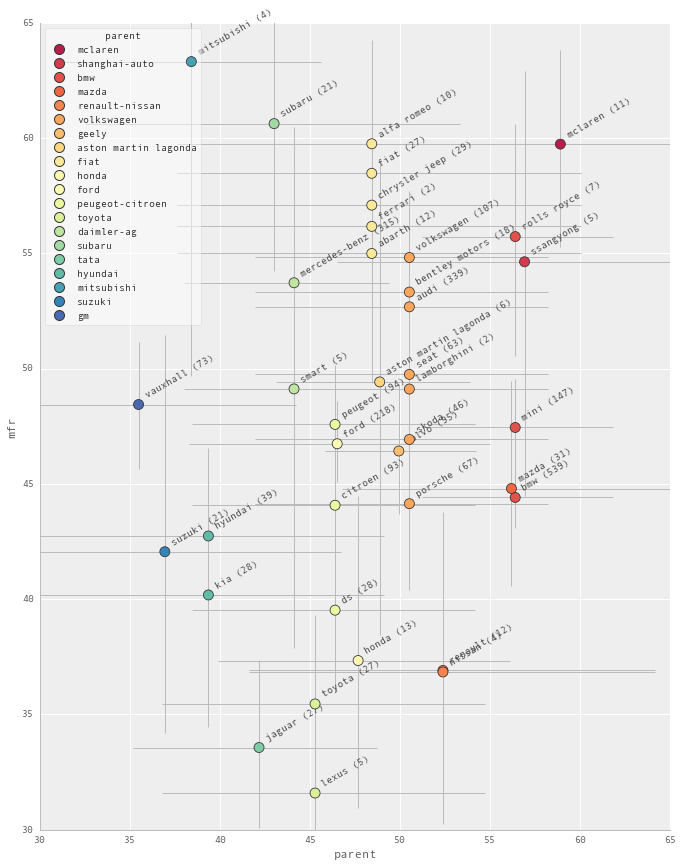

In [65]:
interactive(custom_2d_forestplot, dfg=fixed(dfg), show=['All','Zoom'])

---
**&copy; Applied AI Ltd 2016**  
<a href='http://www.applied.ai'>applied.ai</a>